Необходимо предсказать цену автомобиля, исходя из данных

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data_2.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_') # приведение наименования столбцов к одному виду

df = df.applymap(lambda x: x.lower().replace(' ', '_') if isinstance(x, str) else x) #значения к одному виду
df

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,46120
11910,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,56670
11911,acura,zdx,2012,premium_unleaded_(required),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,50620
11912,acura,zdx,2013,premium_unleaded_(recommended),300.0,6.0,automatic,all_wheel_drive,4.0,"crossover,hatchback,luxury",midsize,4dr_hatchback,23,16,204,50920


<AxesSubplot:xlabel='msrp', ylabel='Count'>

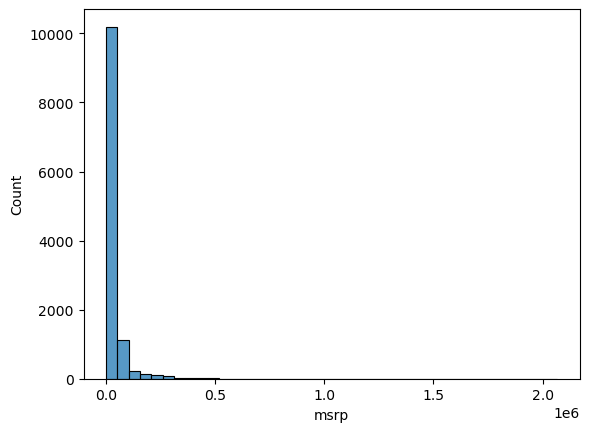

In [4]:
#распределение целевой переменной. Видим, что имеет хвосты справа
sns.histplot(df.msrp, bins=40)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

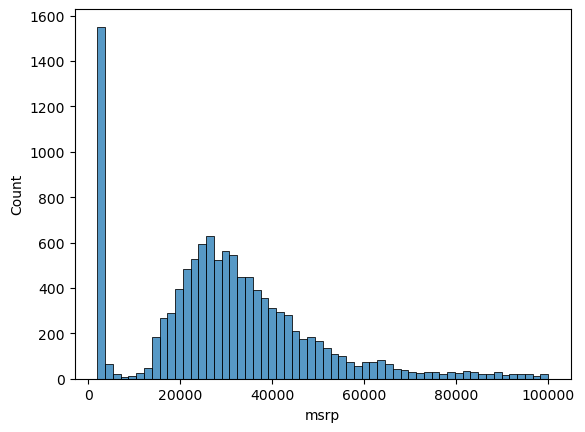

In [5]:
sns.histplot(df.msrp[df.msrp < 100000])

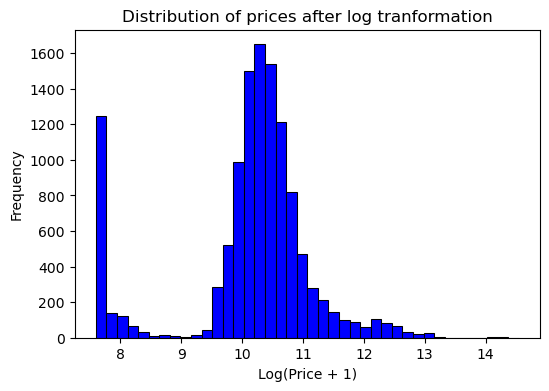

In [6]:
#распределение, близкое к нормальному
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

In [7]:
df.isnull().sum()
#для простоты заменим пропущенные данные 0. В будущем можно попробовать брать среднее исходя из марки автомобиля

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [5]:
#подготовка датафрейма к построению модели
def prepare_X(df):
    df.rename(columns={'year': 'year'}, inplace=True)
    df['age'] = df['year'].astype(int).max() - df['year'].astype(int)#фичу выявил из последующего анализа, так как больше всего коррелирует с годом. 
    df['msrp'] = np.log1p(df['msrp'])#лог цены

    #создание фич с признаками для имеющихся столбцов
    for v in set(df['make']):
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)

    for v in set(df['model']):
        feature = 'is_model_%s' % v
        df[feature] = (df['model'] == v).astype(int)

    for v in set(df['engine_fuel_type']):
        feature = 'is_engine_fuel_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)

    for v in set(df['transmission_type']):
        feature = 'is_transmission_type_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)

    for v in set(df['driven_wheels']):
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)

    for v in set(df['number_of_doors']):
        feature = 'is_number_of_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)

    for v in set(df['market_category']):
        feature = 'is_market_category_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)

    for v in set(df['vehicle_size']):
        feature = 'is_vehicle_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)

    for v in set(df['vehicle_style']):
        feature = 'is_vehicle_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)

    df = df.fillna(0)# пропуски нулями заполняем, чтобы не копаться с анализом, хотя можно взять среднее
    df = df.select_dtypes(include=[np.number])#оставляем только численные признаки, категориальные убираем
    return df

In [6]:
df_1 = prepare_X(df.copy())
df_1

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp,age,is_make_ford,...,is_vehicle_style_2dr_hatchback,is_vehicle_style_coupe,is_vehicle_style_convertible,is_vehicle_style_passenger_minivan,is_vehicle_style_passenger_van,is_vehicle_style_cargo_minivan,is_vehicle_style_4dr_hatchback,is_vehicle_style_4dr_suv,is_vehicle_style_crew_cab_pickup,is_vehicle_style_2dr_suv
0,2011,335.0,6.0,2.0,26,19,3916,10.739349,6,0,...,0,1,0,0,0,0,0,0,0,0
1,2011,300.0,6.0,2.0,28,19,3916,10.612779,6,0,...,0,0,1,0,0,0,0,0,0,0
2,2011,300.0,6.0,2.0,28,20,3916,10.500977,6,0,...,0,1,0,0,0,0,0,0,0,0
3,2011,230.0,6.0,2.0,28,18,3916,10.290483,6,0,...,0,1,0,0,0,0,0,0,0,0
4,2011,230.0,6.0,2.0,28,18,3916,10.448744,6,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,2012,300.0,6.0,4.0,23,16,204,10.739024,5,0,...,0,0,0,0,0,0,1,0,0,0
11910,2012,300.0,6.0,4.0,23,16,204,10.945018,5,0,...,0,0,0,0,0,0,1,0,0,0
11911,2012,300.0,6.0,4.0,23,16,204,10.832122,5,0,...,0,0,0,0,0,0,1,0,0,0
11912,2013,300.0,6.0,4.0,23,16,204,10.838031,4,0,...,0,0,0,0,0,0,1,0,0,0


msrp                                               1.000000
year                                               0.768124
engine_hp                                          0.661514
is_engine_fuel_type_premium_unleaded_(required)    0.436958
Name: msrp, dtype: float64


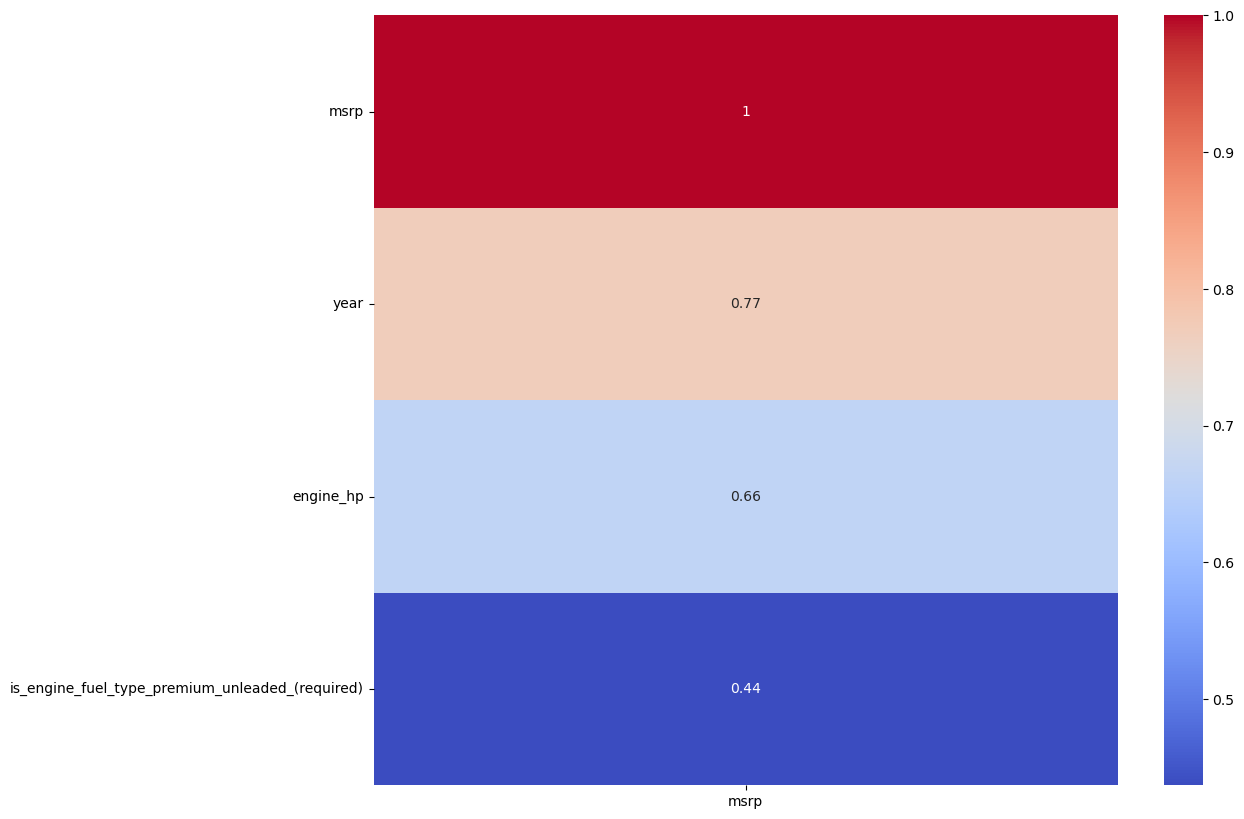

In [27]:
# Корреляция
correlations = df_1.corr()

#Выберем только те столбы, где корреляция > 0.4
most_correlated = correlations['msrp'][correlations['msrp'] >= 0.4].sort_values(ascending=False)
print(most_correlated)

# Построим тепловую карту
filtered_correlations = correlations.loc[most_correlated.index, ['msrp']]
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlations, annot=True, cmap='coolwarm')
plt.show()
    

In [7]:
#разделение наборов. По возьмем 60% -- обучающий набор, 20% -- валидационный, 20% -- тестовый
def split_data(df, val_ratio=0.2, test_ratio=0.2, random_seed=42):
    n = len(df)

    n_val = int(val_ratio * n)
    n_test = int(test_ratio * n)
    n_train = n - (n_val + n_test)

    np.random.seed(random_seed)
    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]# перемешанный датафрейм по индексу

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()

    return df_train, df_val, df_test

# Пример использования
df_train, df_val, df_test = split_data(df_1)
df_train

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity,msrp,age,is_make_ford,...,is_vehicle_style_2dr_hatchback,is_vehicle_style_coupe,is_vehicle_style_convertible,is_vehicle_style_passenger_minivan,is_vehicle_style_passenger_van,is_vehicle_style_cargo_minivan,is_vehicle_style_4dr_hatchback,is_vehicle_style_4dr_suv,is_vehicle_style_crew_cab_pickup,is_vehicle_style_2dr_suv
3995,2005,275.0,6.0,4.0,18,13,549,10.298768,12,0,...,0,0,0,0,0,0,0,1,0,0
7474,2016,170.0,4.0,4.0,38,25,873,10.325351,1,0,...,0,0,0,0,0,0,0,0,0,0
7300,2016,248.0,6.0,4.0,28,19,2202,10.536115,1,0,...,0,0,0,1,0,0,0,0,0,0
3148,2015,138.0,4.0,4.0,36,25,1385,9.690975,2,0,...,0,0,0,0,0,0,0,0,0,0
747,1991,162.0,4.0,4.0,20,17,870,7.601402,26,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10845,2003,207.0,6.0,2.0,17,14,586,9.902287,14,0,...,0,0,0,0,0,0,0,0,0,0
4861,2015,201.0,4.0,4.0,29,21,1720,9.947074,2,0,...,0,0,0,0,0,0,1,0,0,0
2334,2006,150.0,4.0,4.0,24,17,1851,9.832582,11,0,...,0,0,0,1,0,0,0,0,0,0
8651,2005,160.0,4.0,2.0,31,22,204,9.960624,12,0,...,1,0,0,0,0,0,0,0,0,0


In [13]:
#Построим модель. Написал код в таком виде, чтобы убедиться, какие признаки коррелируют и можно сделать вывод, что почти также сходятся с матрицей корр.
"""def train_and_evaluate_model(df):
    # Убираем строки с пропущенными значениями в 'DontCountHits'
    data = df.dropna(subset=['msrp'])

    # Выбираем числовые столбцы
    numeric_columns = data.select_dtypes(include=[np.number])

    # Убираем целевую переменную
    feature_columns = numeric_columns.drop(columns='msrp').columns

    # Создаем модели
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Ridge Regression': Ridge(),
        'Elastic Net': ElasticNet()
    }

    # Цикл для оценки параметров по различным моделям
    for model_name, model in models.items():
        print(f"{model_name}:")
        top_features = []  # Для хранения параметров с лучшими показателями метрик

        for feature_column in feature_columns:
            X = numeric_columns[[feature_column]]
            y = numeric_columns['msrp']

            if X.shape[1] > 0:
                model.fit(X, y)
                predictions = model.predict(X)
                mse = mean_squared_error(y, predictions)
                r2 = r2_score(y, predictions)
                top_features.append((feature_column, mse, r2))

        top_features.sort(key=lambda x: x[1])  # Сортировка
        top_features = top_features[:5]  # Задаем диапазон признаков, в данном случае, выбраны топ-5

        for rank, (feature, mse, r2) in enumerate(top_features, start=1):
            print(f"{rank}: {feature}, MSE: {mse:.4f}, R^2: {r2:.4f}")  # Выводим топ-5 признаков c метриками

result = train_and_evaluate_model(df_train)
result""

Linear Regression:
1: year, MSE: 0.5003, R^2: 0.5888
2: age, MSE: 0.5003, R^2: 0.5888
3: engine_hp, MSE: 0.6946, R^2: 0.4290
4: is_engine_fuel_type_regular_unleaded, MSE: 0.8967, R^2: 0.2629
5: is_engine_fuel_type_premium_unleaded_(required), MSE: 0.9831, R^2: 0.1918
Lasso Regression:
1: age, MSE: 0.5177, R^2: 0.5744
2: year, MSE: 0.5177, R^2: 0.5744
3: engine_hp, MSE: 0.6947, R^2: 0.4289
4: popularity, MSE: 1.2163, R^2: 0.0001
5: engine_cylinders, MSE: 1.2164, R^2: 0.0000
Ridge Regression:
1: year, MSE: 0.5003, R^2: 0.5888
2: age, MSE: 0.5003, R^2: 0.5888
3: engine_hp, MSE: 0.6946, R^2: 0.4290
4: is_engine_fuel_type_regular_unleaded, MSE: 0.8967, R^2: 0.2629
5: is_engine_fuel_type_premium_unleaded_(required), MSE: 0.9831, R^2: 0.1918
Elastic Net:
1: year, MSE: 0.5056, R^2: 0.5844
2: age, MSE: 0.5056, R^2: 0.5844
3: engine_hp, MSE: 0.6946, R^2: 0.4289
4: engine_cylinders, MSE: 1.1524, R^2: 0.0526
5: popularity, MSE: 1.2163, R^2: 0.0001


Linear Regression:
MSE: 0.0227, RMSE: 0.1508, R^2: 0.9813


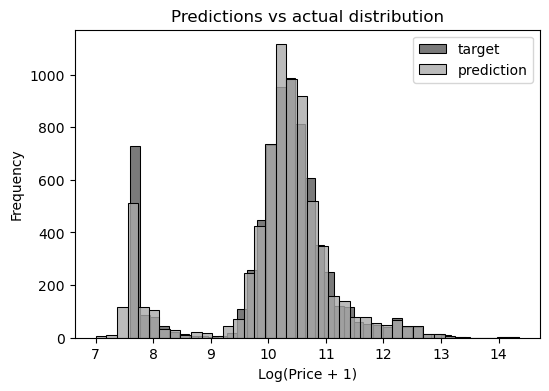

Lasso Regression:
MSE: 0.2969, RMSE: 0.5449, R^2: 0.7559


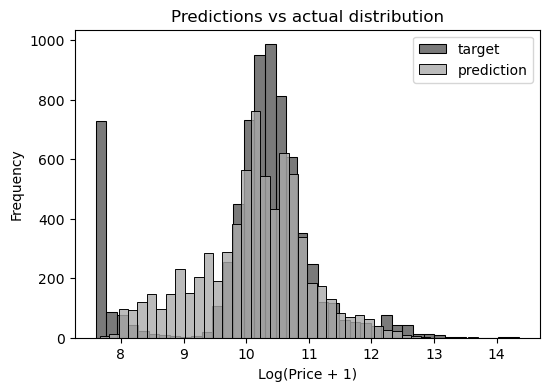

Ridge Regression:
MSE: 0.0320, RMSE: 0.1789, R^2: 0.9737


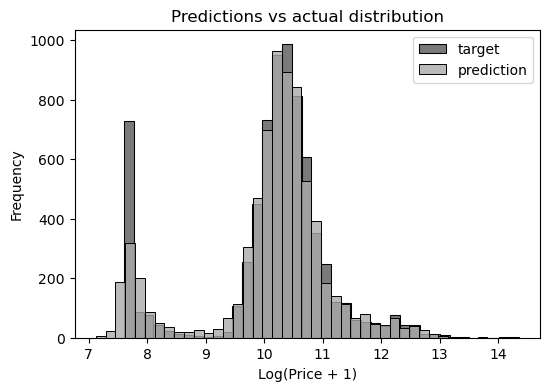

Elastic Net:
MSE: 0.2819, RMSE: 0.5310, R^2: 0.7682


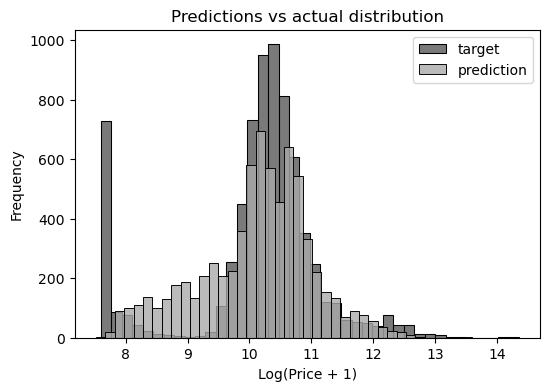

In [28]:
#Посмотрим на метрики модели целиком
def train_and_evaluate_model(df):

    # Создаем модели
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Ridge Regression': Ridge(),
        'Elastic Net': ElasticNet()
    }

    # Цикл для оценки параметров по различным моделям
    for model_name, model in models.items():
        print(f"{model_name}:")
        
        # Собираем все признаки и целевую переменную
        X = df.drop(columns='msrp')
        y = df['msrp']

        if X.shape[1] > 0:
            model.fit(X, y)
            predictions = model.predict(X)
            mse = mean_squared_error(y, predictions)
            rmse = np.sqrt(mse)
            r2 = r2_score(y, predictions)

            print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")
            plt.figure(figsize=(6, 4))

            sns.histplot(y, label='target', color='#222222', alpha=0.6, bins=40)
            sns.histplot(predictions, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

            plt.legend()

            plt.ylabel('Frequency')
            plt.xlabel('Log(Price + 1)')
            plt.title('Predictions vs actual distribution')

            plt.show()

# Пример использования функции
result = train_and_evaluate_model(df_train)
result

Метрики показывают хороший результат модели, однако высокий коэф. вариации говорит о том, что модель может быть переобучена, поэтому следует проверить модель на проверочном наборе

Linear Regression:
Validation MSE: 1240213439975.5483, Validation RMSE: 1113648.7058, Validation R^2: -1037317623204.4409
MSE: 1240213439975.5483, RMSE: 1113648.7058, R^2: -1037317623204.4409


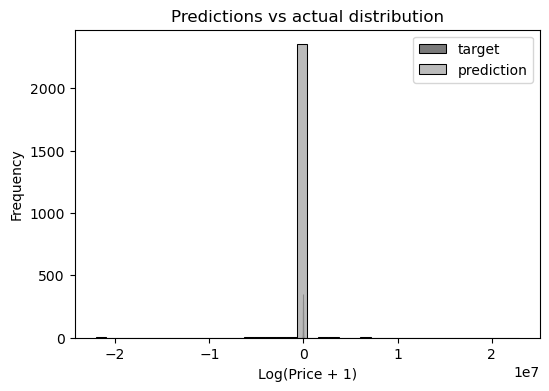

Lasso Regression:
Validation MSE: 0.2808, Validation RMSE: 0.5299, Validation R^2: 0.7651
MSE: 0.2808, RMSE: 0.5299, R^2: 0.7651


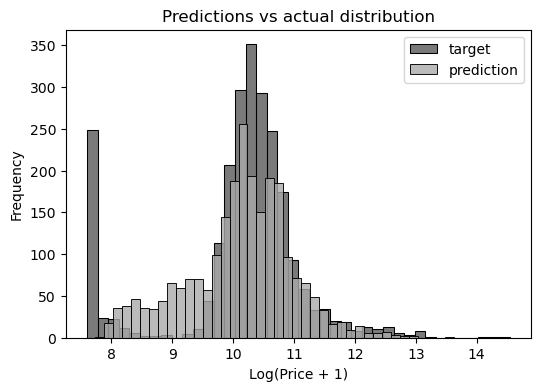

Ridge Regression:
Validation MSE: 0.0476, Validation RMSE: 0.2181, Validation R^2: 0.9602
MSE: 0.0476, RMSE: 0.2181, R^2: 0.9602


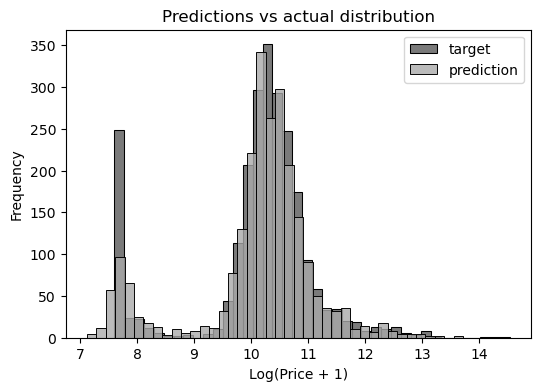

Elastic Net:
Validation MSE: 0.2688, Validation RMSE: 0.5185, Validation R^2: 0.7752
MSE: 0.2688, RMSE: 0.5185, R^2: 0.7752


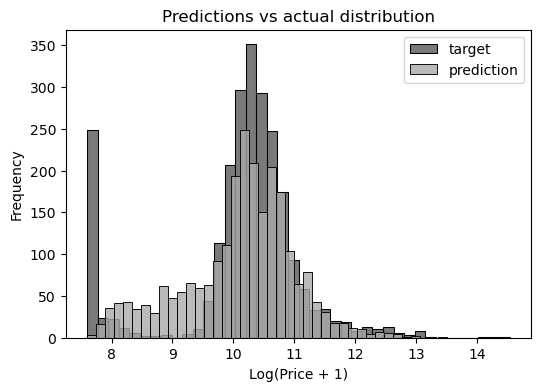

In [22]:
def train_and_evaluate_model(train_df, val_df): # с добавлением проверочного набора
    # Убираем строки с пропущенными значениями в 'msrp'(на всякий)
    train_data = train_df.dropna(subset=['msrp'])
    val_data = val_df.dropna(subset=['msrp'])

    # Выбираем числовые столбцы
    numeric_columns_train = train_data.select_dtypes(include=[np.number])
    numeric_columns_val = val_data.select_dtypes(include=[np.number])


    # Создаем модели
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Ridge Regression': Ridge(),
        'Elastic Net': ElasticNet()
    }

    # Цикл для оценки параметров по различным моделям
    for model_name, model in models.items():
        print(f"{model_name}:")
        
        # Обучение модели на обучающем наборе
        X_train = numeric_columns_train.drop(columns='msrp')
        y_train = numeric_columns_train['msrp']

        if X_train.shape[1] > 0:
            model.fit(X_train, y_train) #по-прежнему обучаем на обучающем наборе

        # а тут делаем предсказания на валидационном наборе
        X_val = numeric_columns_val.drop(columns='msrp')
        y_val = numeric_columns_val['msrp']

        if X_val.shape[1] > 0:
            predictions_val = model.predict(X_val)
            mse_val = mean_squared_error(y_val, predictions_val)
            rmse_val = np.sqrt(mse_val)
            r2_val = r2_score(y_val, predictions_val)

            print(f"Validation MSE: {mse_val:.4f}, Validation RMSE: {rmse_val:.4f}, Validation R^2: {r2_val:.4f}")

            print(f"MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, R^2: {r2_val:.4f}")
            plt.figure(figsize=(6, 4))

            sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
            sns.histplot(predictions_val, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

            plt.legend()

            plt.ylabel('Frequency')
            plt.xlabel('Log(Price + 1)')
            plt.title('Predictions vs actual distribution')

            plt.show()

# Пример использования функции
result = train_and_evaluate_model(df_train, df_val)
result 

Делаем вывод, что модель линейной регрессии переобучена. Лучше всего наши данные описывает модель RidgeRegression. Теперь можно подобрать гиперпараметры, чтобы улучшить предсказание модели(не делал)

Linear Regression:
Validation MSE: 1240213439975.5483, Validation RMSE: 1113648.7058, Validation R^2: -1037317623204.4409


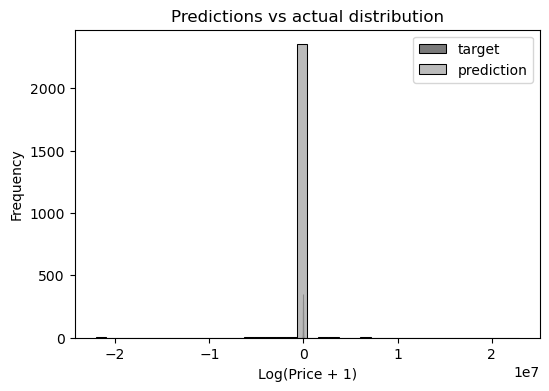

Test MSE: 787332040106.6292, Test RMSE: 887317.3277, Test R^2: -621162331532.1805


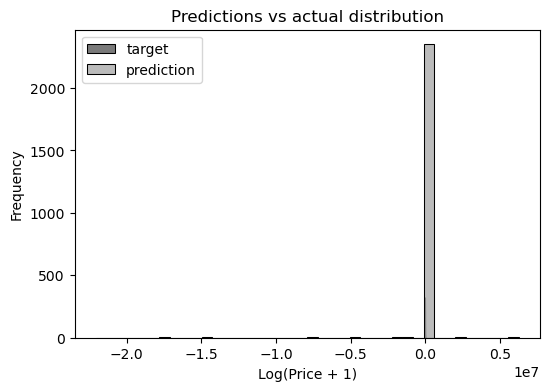

Lasso Regression:
Validation MSE: 0.2808, Validation RMSE: 0.5299, Validation R^2: 0.7651


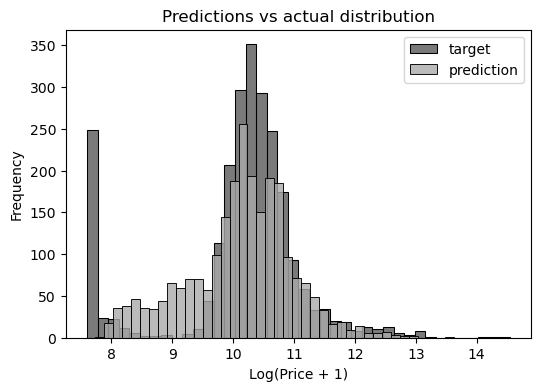

Test MSE: 0.2930, Test RMSE: 0.5413, Test R^2: 0.7688


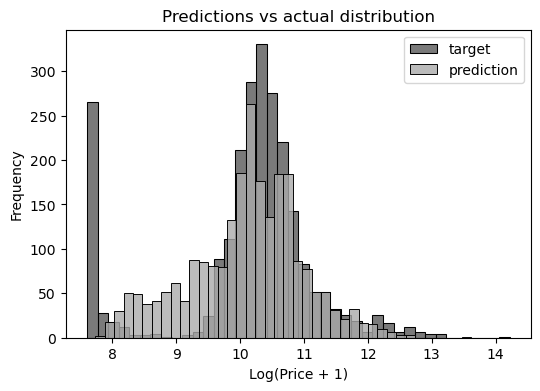

Ridge Regression:
Validation MSE: 0.0476, Validation RMSE: 0.2181, Validation R^2: 0.9602


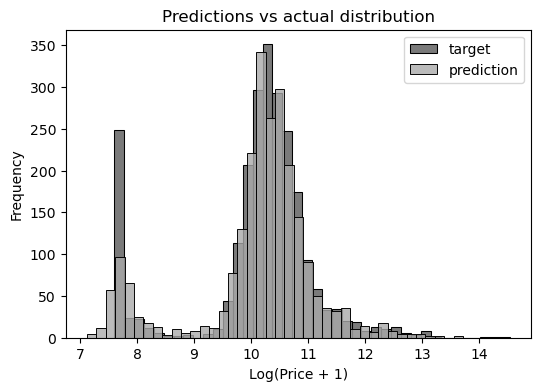

Test MSE: 0.0453, Test RMSE: 0.2128, Test R^2: 0.9643


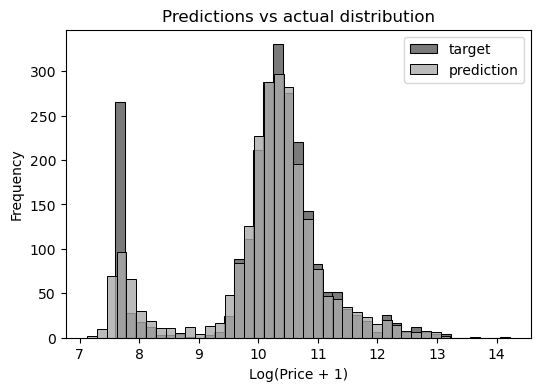

Elastic Net:
Validation MSE: 0.2688, Validation RMSE: 0.5185, Validation R^2: 0.7752


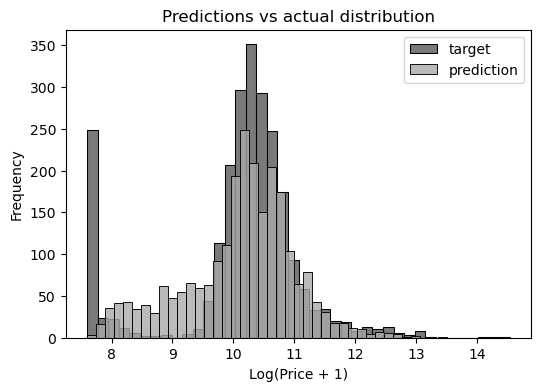

Test MSE: 0.2777, Test RMSE: 0.5269, Test R^2: 0.7809


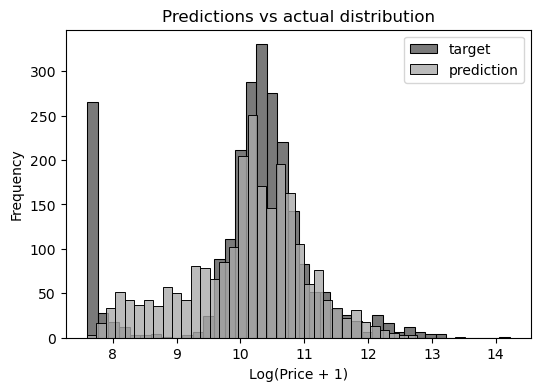

In [23]:
#добавим еще тестовый набор, чтобы подтвердить, что RidgeRegression -- лучшая модель
def train_and_evaluate_model(train_df, val_df, test_df):
    # Убираем строки с пропущенными значениями в 'msrp'
    train_data = train_df.dropna(subset=['msrp'])
    val_data = val_df.dropna(subset=['msrp'])
    test_data = test_df.dropna(subset=['msrp'])

    # Выбираем числовые столбцы
    numeric_columns_train = train_data.select_dtypes(include=[np.number])
    numeric_columns_val = val_data.select_dtypes(include=[np.number])
    numeric_columns_test = test_data.select_dtypes(include=[np.number])

    # Создаем модели
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso Regression': Lasso(),
        'Ridge Regression': Ridge(),
        'Elastic Net': ElasticNet()
    }

    # Цикл для оценки параметров по различным моделям
    for model_name, model in models.items():
        print(f"{model_name}:")
        
        # Обучение модели на обучающем наборе
        X_train = numeric_columns_train.drop(columns='msrp')
        y_train = numeric_columns_train['msrp']

        if X_train.shape[1] > 0:
            model.fit(X_train, y_train)

        # Предсказание на валидационном наборе
        X_val = numeric_columns_val.drop(columns='msrp')
        y_val = numeric_columns_val['msrp']

        if X_val.shape[1] > 0:
            predictions_val = model.predict(X_val)
            mse_val = mean_squared_error(y_val, predictions_val)
            rmse_val = np.sqrt(mse_val)
            r2_val = r2_score(y_val, predictions_val)

            print(f"Validation MSE: {mse_val:.4f}, Validation RMSE: {rmse_val:.4f}, Validation R^2: {r2_val:.4f}")

            # Визуализация предсказаний на валидационном наборе
            plt.figure(figsize=(6, 4))
            sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
            sns.histplot(predictions_val, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)
            plt.legend()
            plt.ylabel('Frequency')
            plt.xlabel('Log(Price + 1)')
            plt.title('Predictions vs actual distribution')
            plt.show()

        # Предсказание на тестовом наборе
        X_test = numeric_columns_test.drop(columns='msrp')
        y_test = numeric_columns_test['msrp']

        if X_test.shape[1] > 0:
            predictions_test = model.predict(X_test)
            mse_test = mean_squared_error(y_test, predictions_test)
            rmse_test = np.sqrt(mse_test)
            r2_test = r2_score(y_test, predictions_test)

            print(f"Test MSE: {mse_test:.4f}, Test RMSE: {rmse_test:.4f}, Test R^2: {r2_test:.4f}")

            # Визуализация предсказаний на тестовом наборе
            plt.figure(figsize=(6, 4))
            sns.histplot(y_test, label='target', color='#222222', alpha=0.6, bins=40)
            sns.histplot(predictions_test, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)
            plt.legend()
            plt.ylabel('Frequency')
            plt.xlabel('Log(Price + 1)')
            plt.title('Predictions vs actual distribution')
            plt.show()

# Пример использования функции
train_and_evaluate_model(df_train, df_val, df_test)


Видим, что тестовая выборка по-прежнему показывает, что RidgeRegression -- лучшая модель для наших данных, так как метрики mse, rmse ниже, чем на валидационном наборе, а R^2 выше.
Чтобы достигнуть лучшего результата, необходимо подобрать гиперпараметры для лучшего обучения модели(-ей)